# Referenced ODMR Analysis

Author: Ryan Corbyn, 28th May 2021

This code makes use of many of the same methods as the CW ODMR dataset to analyse the datasets that are recorded with the microwave switch in place to allow for each ODMR frequency pixel point to be referenced to either a fixed ODMR frequnecy or to a empty channel with no microwaves applied. 

In [2]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd
from scipy.signal import find_peaks

We start the code by loading in the dataset, the parameters file and the plot parameters.  

In [3]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [4]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Creates a numpy array with the microwave frequency scan range from the params file. 

In [6]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

Normalise the ODMR data to the Reference data. Then find the mean of the normalised data. 

In [7]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2] + 1)
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 
    odmr_shape_3D = odmr_data.reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data.reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

In [8]:
def normalise_data(reference_data, odmr_data):
    '''Here we normalise the ODMR dataset to the reference data.'''

    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

In [9]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data_points =  np.mean(odmr_data, axis = 2)
    mean_odmr_data_points_and_linescans =  np.mean(mean_odmr_data_points, axis = 0)
    return(mean_odmr_data_points, mean_odmr_data_points_and_linescans)

In [10]:
def stich_datasets(odmr_data, reference_data):
    '''This method is designed to stitch the ODMR and reference datasets 
    together when the switch has been bypassed in the microwave circuit setup.'''
    
    stitched_data = []
    for i in range(len(odmr_data[:,1])):
        stitched_data.append(odmr_data[i,:])
        stitched_data.append(reference_data[i,:])
    
    stitched_data = np.array(stitched_data)
    
    return(stitched_data)

Generates a scatter plot of the mean noramlised ODMR data. 

In [11]:
def scatter_plot(freq, mean_data, dwell_time):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Counts per ' + str(dwell_time) + r'$\mu$s', fontsize = 18)
    return(fig2, ax2)

In [12]:
def normalised_scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts (A.U.)', fontsize = 18)
    return(fig2, ax2)

Find the initial parameters for the double lorentz fitting for the dataset, along with the code that is required for the lorentz fitting to be performed. 

In [13]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) - 5 # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [14]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [15]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

Plot the fitting of the double lorentzian line shape and adds the labels and legends to the graphs. 

In [16]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    
    return(ax2, y_fit)

In [17]:
def get_fitting_contrast(res_freq1, res_freq2, freq, y_fit, baseline, step):
    
    step = str(step/1000) # step size in GHz and string
    decimals = step[::-1].find('.') # find the number of decimal points in the steps. 
    
    first_freq_min_index = (np.abs(freq-round(res_freq1, decimals))).argmin()
    second_freq_min_index =(np.abs(freq-round(res_freq2, decimals))).argmin()

    contrast = [(baseline - y_fit[first_freq_min_index])/baseline, (baseline - y_fit[second_freq_min_index])/baseline]
    
    return(contrast)

Find the R squared value for the fitting verses the actual dataset. 

In [18]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

The method to save the data into a folder on the iDrive. 

In [19]:
def save_data(date, file_ID, fitted_contrast, coeffs, opt_error, r_squared, fig1):
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\' #+ 'power_sweep\\'
    output_data_file = destination_folder + date + '_reference_ODMR_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name'  + '\t' +
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency 2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' + 
                     'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID  + '\t' +
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(fitted_contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(fitted_contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    #fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    #fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig1.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '.png', transparent = True) 

### Code starts here 

Here we set the folder directory and the file names of the datasets. We then load the dataset into the numpy arrays and generates the frequnecy array for the scans performed and the dwell time of the pixels used.

In [20]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

date = '20210614' # Date on folder in which the experimental data is saved. 
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\' + date + '\\'
#folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'

data_set = '_referenced_odmr_11' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
file_name_ODMR1 = date + data_set + '_ODMR1.dat'
file_name_ODMR2 = date + data_set + '_ODMR2.dat'
file_name_Ref1 = date + data_set  + '_Ref1.dat'
file_name_Ref2 = date + data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
odmr_data = load_data(folder_path + file_name_ODMR1)
reference_data = load_data(folder_path + file_name_Ref1)

# Get the parameters for the experiment. 
params_file = load_params(folder_path + date  + data_set + '_Params.txt')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Dwell time of the measurment 
dwell_time = params_values[3]

## Script Note

This next part of the script will set whether the microwave switch was used for the experiments, which will determine what parts of the code are used. 

In [21]:
microwave_switch = 'on'
print(params_values)

odmr_data, reference_data = reshape_data(reference_data, odmr_data, params_values)

0        2.80
1        2.95
2        1.00
3    10000.00
4        1.00
5        0.00
6    10000.00
7        0.00
8      100.00
Name: Parameter value, dtype: float64
1 151 100


Here we normalise the ODMR data to the reference data and then find the mean of this normalised data. The code then works to determine the fitting of the double lorentzian to the ODMR data and find the R squared value for the fitting to the data. 

Contrast = [0.050364123837966186, 0.05246492626979922]
r squared = 0.9650073515272523


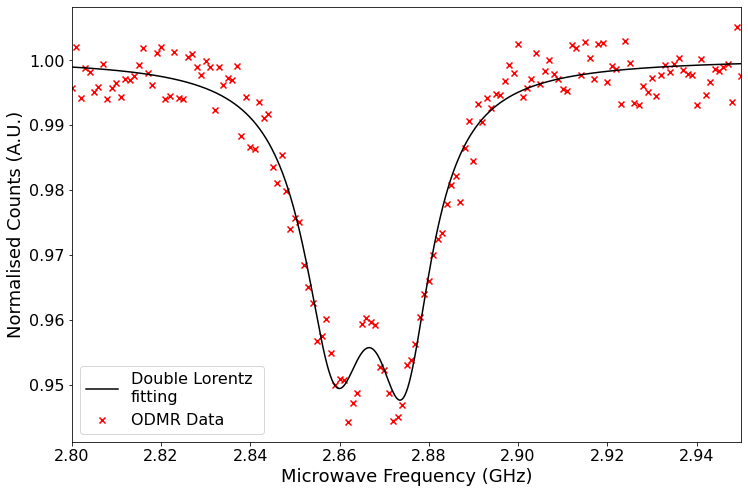

In [22]:
if microwave_switch == 'off':
    # Stitch the data together, 
    stitched_data = stich_datasets(odmr_data, reference_data)
    # Find the mean of the data. 
    # mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
    # mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
    mean_odmr_freq_points, mean_norm_odmr_full = mean_data(stitched_data)
else: 
    # Normalise the ODMR data against the reference data. 
    normalised_ODMR = normalise_data(reference_data, odmr_data)

    # Mean of the normalise dataset. 
    # mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
    # mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
    mean_odmr_freq_points, mean_norm_odmr_full = mean_data(normalised_ODMR)
 
    
# Plot the mean normalised dataset as a scatter plot. 
fig1, ax1 = normalised_scatter_plot(freq, mean_norm_odmr_full)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_norm_odmr_full, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]
#init_params = [-0.8, 2.85, 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]

# Set the upper and lower bounds for the fitting algorithm. 
lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_norm_odmr_full, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax2
ax1, y_fit = plot_fitting(ax1, freq, params_values[3])

fitted_contrast = get_fitting_contrast(fitting_params[1], fitting_params[4], freq, y_fit,  fitting_params[6], params_values[2])
print('Contrast = ' + str(fitted_contrast))

# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, mean_norm_odmr_full, y_fit)
print('r squared = ' + str(r_squared))

In [23]:
# Save the data. 

#save_data(date, file_name_ODMR1, fitted_contrast, coeffs, opt_error, r_squared, fig1)

151


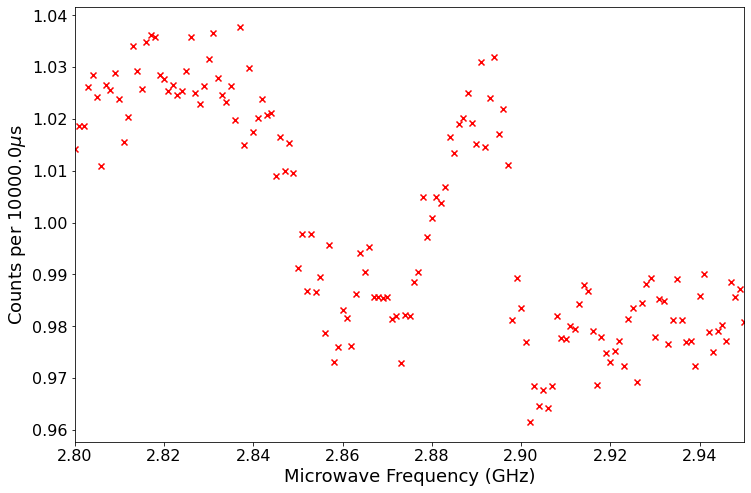

In [24]:
mean_odmr_data, mean_odmr_everything = mean_data(odmr_data)
print(len(mean_odmr_everything))
fig2, ax2 = scatter_plot(freq, mean_odmr_everything/np.mean(mean_odmr_everything), dwell_time)

In [25]:
print(odmr_data.shape)

(1, 151, 100)


# 2-4 point thermometry

The next seciton of this code aims to utilise the algorithm that is reported in the paper: "Nitrogen-vacancy nanodiamond based local thermometry using frequency-jump modulation". 

The focus of this work is to perform thermometry using just 2 frequency points that are centred on the linear portion of the ODMR curve. This section of the curve will be the most sensitive to changes in temperature due to the step gradient of the curve at this section. 

Due to the nature of the NV centre resonant frequency shift as a result of a change in temperature, as the temperature increases from the steady state value at which the system was calibrated. For each of the 2 frequencies, the fluorescence intensity from the NV will either drop or increase respectively, depending on the magnitude of the temperature change. 

I look to exploit this behaviour here, along with the fact that we record 4 ODMR datapoints just to either side of the mid-point of the straight line section of the ODMR curve for the 4 point thermometry we are already planning to implement. 




### Code description

This next section of the code is to be used if the used wants to extract 4 points along the ODMR curve for NDs that are not subject to an external magnetic field. 

The code will work by: 
1. Taking the fitted ODMR curve and extracting the linear portions of the positive and negative gradients. 
2. Find the mid point of the straight line secitons of the lorentz fitting. 
3. Select two points from both the negative and positive gradients of the fitting that still lie within the linear portion of the graph. 
4. using the mid-point of the stright section of the fitted double-lorenzian fittin, I will generate the calibration curves for the temperature measurement using the 6 possible data-points availible to myself. 
5. The "reference" dataset from the lorentz fitting and the actually ODMR data are then compared to see if it is possible that the modified 2 point ODMR thermometry will work with the data-set provided. 

In [26]:
def get_straight_lines(y_data):
    '''This method extracts the straight line fits from the y fit data.'''
    
    # If you want to have multiple conditions for the "finding" algorithm np.where
    # We apparently need to use brackets and the " * " symbol. 
    minima_indicies = np.where((y_data[1:-1] < y_data[0:-2]) * (y_data[1:-1] < y_data[2:]))[0] + 1
    
    # Separate the dataset into all the indcies below and above these minima indicies. 
    divided_dataset = []
    
    # If the ND was subject to a B field and now has multiple (more than 2) separate ODMR dips
    if len(minima_indicies) > 2: 
        start = 0
        for i in range(len(minima_indicies)):
            # This should get the negative gradient straight line from an 
            # ODMR curve fitting. 
            divided_dataset.append(np.arange(start, minima_indicies[i], 1))
            
            # Find the point that lies between 2 ODMR dips to find the positive 
            # Gradient sention of a B field split ODMR curve. 
            # We use try and except to catch the very last peak in the dataset. 
            try:
                half_way = int((minima_indicies[i] + minima_indicies[i+1])/2)
            except: 
                half_way = len(y_data)-1
            # We should capture the positive gradient section of an ODMR dip here. 
            start = half_way[i]
            divided_dataset.append(np.arange( minima_indicies[i], start, 1))
    
    else: 
        divided_dataset.append(np.arange(0, minima_indicies[0], 1))
        divided_dataset.append(np.arange(minima_indicies[1], len(y_data)-1, 1))
    
    # Set the parameters for the straight line condition for the lorentz fitting.
    # These have been chosen arbitrarily from the above fitting. 
    # I'll need to find a good way of automating this. 
    max_cutoff = 0.98
    min_a_cutoff = 0.950
    offset = 0
    
    for i in range(int(len(divided_dataset)/2)):
        negative_gradient_line = np.where((y_data[divided_dataset[i]] < max_cutoff) * 
                                          (y_data[divided_dataset[i]] > min_a_cutoff))[0] + offset
        positive_gradient_line = np.where((y_data[divided_dataset[i+1]] < max_cutoff) * 
                                          (y_data[divided_dataset[i+1]] > min_a_cutoff))[0] + minima_indicies[i+1]
        offset = minima_indicies[i]
    
    
    return(negative_gradient_line, positive_gradient_line)

In [27]:
def linear_fit(x, m, c):
    '''m = gradient, c = y intercept'''
    y = m*x + c
    return(y)

In [28]:
def half_way(y_linear_neg, mid_value_a, y_linear_pos):
    '''Find the mid-point of the negative gradient straight-line portion of the ODMR curve
    and then use this to find the freq that corresponds to the closest y value in the 
    positive gradient of the ODMR curve.'''
    
    mid_intensity_neg = y_linear_neg[mid_value_a]
    
    index_mid_intensity_pos = (np.abs(y_linear_pos-mid_intensity_neg)).argmin()
    print(index_mid_intensity_pos)

In [29]:
# Start the 4 point analysis

# First off we extract the linear portion of the straight line fitting. 
straight_line_index_neg, straight_line_index_pos  = get_straight_lines(y_fit)

# Extract the middle value and the two values either side of it. 

mid_value_a = int(np.ceil( len(straight_line_index_neg) / 2) + straight_line_index_neg[0])
mid_value_b = int(np.ceil( len(straight_line_index_pos) / 2) + straight_line_index_pos[0]) - 1

# Select the 4 points for the fast ODMR.
four_points_index = [mid_value_a - 1, mid_value_a + 1, mid_value_b - 1, mid_value_b + 1]    
four_freqs = freq[four_points_index]

# Fit a linear curve to the straight line fittings. 
p0 = [1,1]
fit_neg, confidence_neg = opt.curve_fit(linear_fit, freq[straight_line_index_neg], y_fit[straight_line_index_neg], p0)
y_neg = linear_fit(freq[straight_line_index_neg], fit_neg[0], fit_neg[1])

fit_pos, confidence_pos = opt.curve_fit(linear_fit, freq[straight_line_index_pos], y_fit[straight_line_index_pos], p0)
y_pos = linear_fit(freq[straight_line_index_pos], fit_pos[0], fit_pos[1])


In [30]:
# Find the straight line gradients for the 2 points frequnecy points to be used for the 4 point ODMR scans
#neg_gradient, neg_y_intercept, pos_gradient, pos_y_intercept = two_point_line(four_freqs,  y_fit[four_points_index])

#neg_pos_intersection_freq = (pos_y_intercept - neg_y_intercept) / (pos_gradient - neg_gradient)
#print(neg_pos_intersection_freq)

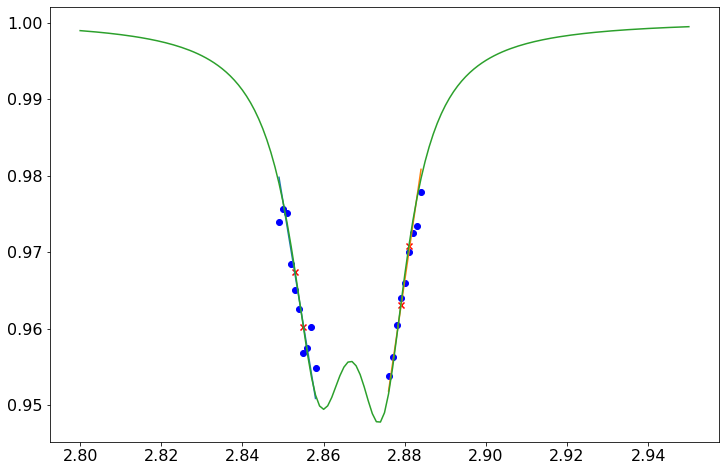

In [31]:
plot.scatter(freq[straight_line_index_neg], mean_norm_odmr_full[straight_line_index_neg], color = 'b')
plot.scatter(freq[straight_line_index_pos], mean_norm_odmr_full[straight_line_index_pos], color = 'b')

plot.plot(freq[straight_line_index_neg], y_neg)
plot.plot(freq[straight_line_index_pos], y_pos)

plot.scatter(four_freqs, y_fit[four_points_index], color = 'r', marker = 'x')
plot.plot(freq, y_fit)

In [32]:
two_points = four_freqs[0:1]
y_points = y_fit[four_points_index[0:1]]
lower_bounds = [-10, 0]
upper_bounds = [0, 10]
fit, con = opt.lsq_linear(two_points, y_points, bounds = (-10, 0) )

ValueError: too many values to unpack (expected 2)

In [33]:
print(mid_value_a, mid_value_b)

54 80


In [34]:
freq_step_diff = mid_value_b - mid_value_a
half_step = int(np.floor(freq_step_diff/2)) 
intensity_diff = np.zeros([3, (len(y_fit)-freq_step_diff-half_step)-1])
print(intensity_diff.shape)

tester = np.zeros([1, (len(y_fit)-freq_step_diff-half_step)-1])

for i in range(len(intensity_diff[0,:])): 
    intensity_diff[0, i] = y_fit[i ] - y_fit[i + freq_step_diff ]
    tester[0,i] = mean_norm_odmr_full[i ] - mean_norm_odmr_full[i + freq_step_diff ]
    
for i in range(len(intensity_diff[0,1:-1])): 
    intensity_diff[1, i] = y_fit[i] - y_fit[i + freq_step_diff + 2]

for i in range(len(intensity_diff[0,:])): 
    intensity_diff[2, i] = y_fit[i] - y_fit[i + freq_step_diff - 2]

(3, 111)


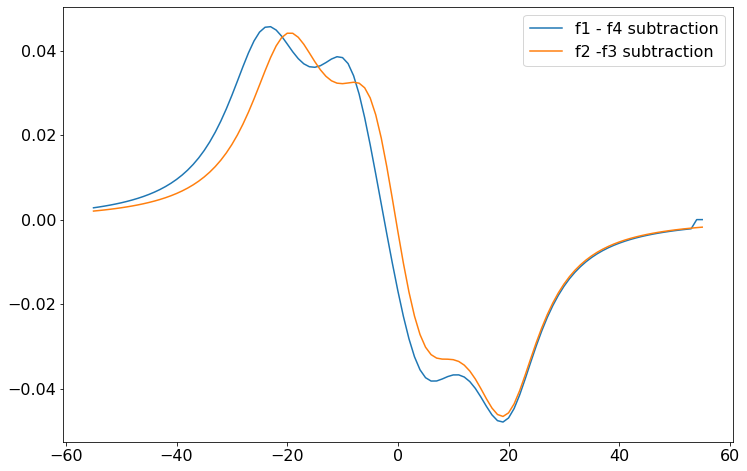

In [41]:

x0 = np.linspace(-int((len(intensity_diff[0,:])-1)/2), int((len(intensity_diff[0,:])-1)/2), len(intensity_diff[0,:]))
#plot.plot(x0[45:62], intensity_diff[0,45:62], label = 'Mid-point subtraction')
#plot.plot(x0[45:62], tester[0,45:62])

#plot.plot(x0, intensity_diff[0,:], label = 'Mid-point subtraction')
#plot.plot(x0, tester[0,:])

plot.plot(x0, intensity_diff[1,:], label = 'f1 - f4 subtraction')
plot.plot(x0, intensity_diff[2,:], label = 'f2 -f3 subtraction')
plot.legend()

In [130]:
print(50/0.075)

666.6666666666667
